# Investigation #2:
### Difficulty of questions answered over time.  
E.g.: Do people tend to answer harder questions as they are on the site longer.  
Metrics: How long was the question open for, how many upvotes does the most popular answer have compared to other answers  

We import needed libraries

In [1]:
import xml.etree.ElementTree as ET
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cm as cm
import numpy as np
from matplotlib.cm import rainbow
import seaborn as sns

We parse the "Posts" data file into a Data frame for easier use

In [2]:
tree = ET.parse('../XML-Data/Posts.xml')
root = tree.getroot()

posts_data = []
for post in root:
    posts_data.append(post.attrib)
    
posts_df = pd.DataFrame(posts_data)

We change the Creation Date column format to date time

In [3]:
posts_df['CreationDate'] = pd.to_datetime(posts_df['CreationDate'])

We filter questions and answers

In [4]:
# Filter out questions and answers
questions_df = posts_df[posts_df['PostTypeId'] == '1'].copy()
answers_df = posts_df[posts_df['PostTypeId'] == '2'].copy()

In [5]:
questions_df['CreationDate'] = pd.to_datetime(questions_df['CreationDate'])
answers_df['CreationDate'] = pd.to_datetime(answers_df['CreationDate'])

We filter users with more than 20 questions and name as active users

In [6]:
# Filter users with more than 20 questions and name as active users
user_question_counts = posts_df['OwnerUserId'].value_counts()
active_users = user_question_counts[user_question_counts > 20].index

We get the active users questions and their respective answers

In [7]:
active_user_questions = questions_df[questions_df['OwnerUserId'].isin(active_users)]
active_user_answers = answers_df[answers_df['ParentId'].isin(active_user_questions['Id'])]

In [8]:
# Convert 'first_answers' to a DataFrame and rename the column
# Group by 'ParentId' and find the first answer date for each question
first_answers = answers_df.groupby('ParentId')['CreationDate'].min()

first_answers_df = first_answers.reset_index()
first_answers_df = first_answers_df.rename(columns={'CreationDate': 'FirstAnswerDate'})

In [9]:
active_user_questions = active_user_questions.merge(first_answers_df, left_on='Id', right_on='ParentId', how='left')
active_user_questions['TimeToFirstAnswer'] = active_user_questions['FirstAnswerDate'] - active_user_questions['CreationDate']

### Evolution of Response Time for Active Users
plot to visualize the evolution of response times for active users on Stack Exchange. The plot will display how the time to receive the first answer to users' questions changes over time.

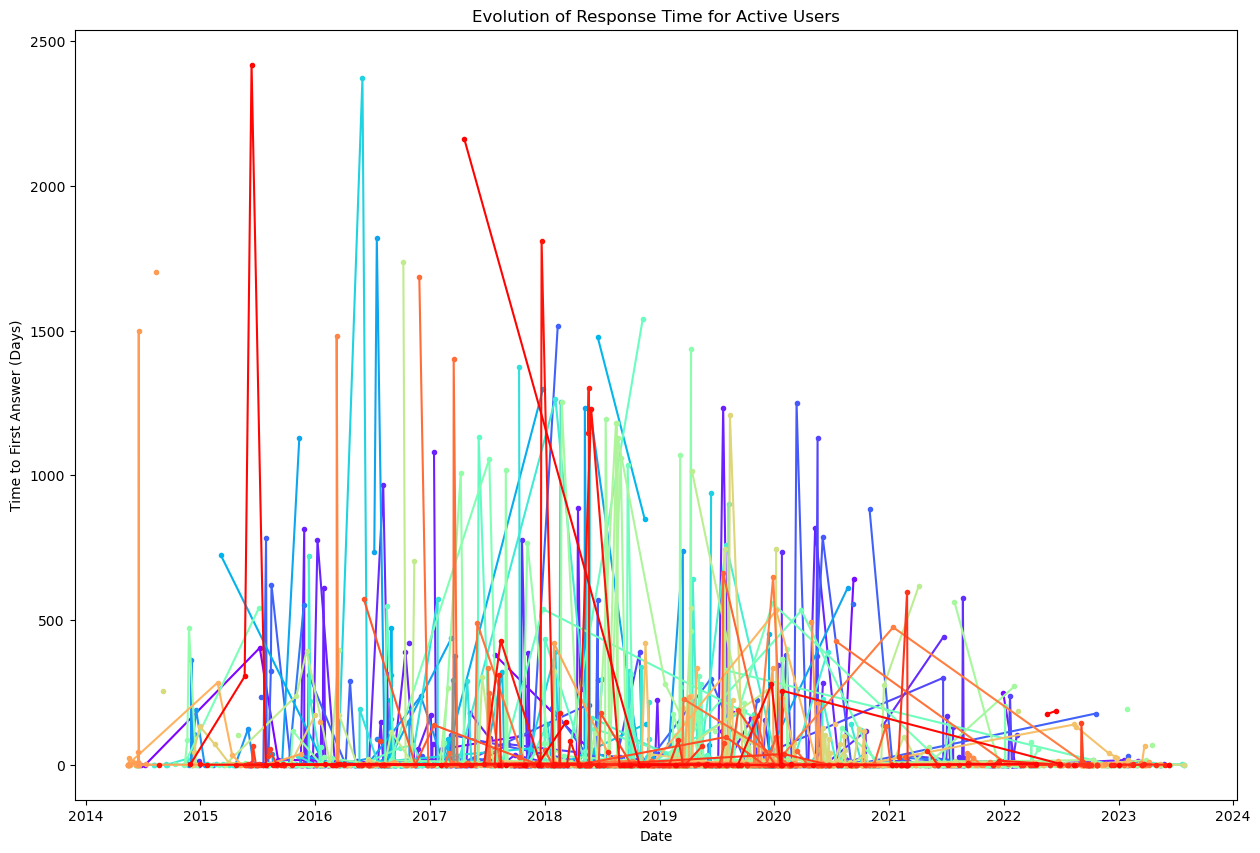

In [15]:
# Plotting
plt.figure(figsize=(15, 10))
colors = cm.rainbow(np.linspace(0, 1, len(active_users)))

for user, color in zip(active_users, colors):
    user_data = active_user_questions[active_user_questions['OwnerUserId'] == user]
    user_data = user_data.sort_values(by='CreationDate')
    plt.plot(user_data['CreationDate'], user_data['TimeToFirstAnswer'].dt.days, label=user, color=color, marker='.')
plt.xlabel('Date')
plt.ylabel('Time to First Answer (Days)')
plt.title('Evolution of Response Time for Active Users')
plt.show()

## Linear Regression Analysis 
Here we are performing and visualizing a linear regression analysis on the average time it takes 
for questions to receive their first answer on Stack Exchange, aggregated on a monthly basis for a better view of the data.

1. Data Preparation: we convert the TimeToFirstAnswer column from a timedelta object (which represents a duration) to a numeric value representing the number of days. It calculates the total seconds and then divides by the number of seconds in a day (24 hours * 60 minutes * 60 seconds).
2. Data Aggregation: we group the data by month based on the CreationDate column and calculates the mean (average) TimeToFirstAnswerDays for each month.
3. Linear Regression Setup.
4. Performing Linear Regression.


/var/folders/mc/sqtx85kj6bq3fbcvf9zfkdj40000gp/T/ipykernel_50698/2788671435.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  monthly_data = active_user_questions.resample('M', on='CreationDate').mean().dropna()


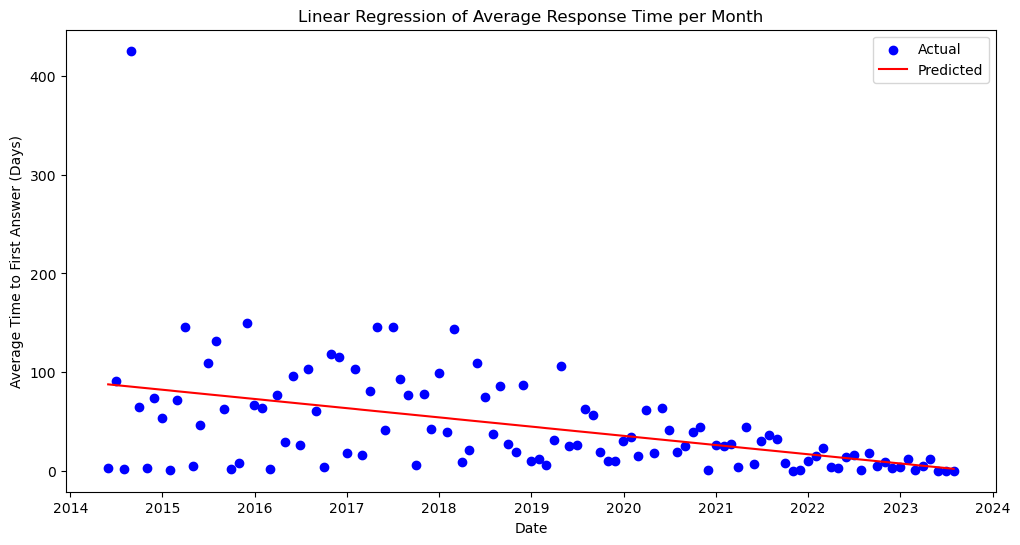

In [16]:
from sklearn.linear_model import LinearRegression

active_user_questions['TimeToFirstAnswerDays'] = active_user_questions['TimeToFirstAnswer'].dt.total_seconds() / (24 * 3600)
# aggregate the data by month for the regression
monthly_data = active_user_questions.resample('M', on='CreationDate').mean().dropna()

# Prepare the data for regression
X = np.array(range(len(monthly_data))).reshape(-1, 1)
y = monthly_data['TimeToFirstAnswerDays'].values

# apply linear regression
model = LinearRegression()
model.fit(X, y)

# predict values
predicted = model.predict(X)

# plot  results
plt.figure(figsize=(12, 6))
plt.scatter(monthly_data.index, y, color='blue', label='Actual')
plt.plot(monthly_data.index, predicted, color='red', label='Predicted')

plt.xlabel('Date')
plt.ylabel('Average Time to First Answer (Days)')
plt.title('Linear Regression of Average Response Time per Month')
plt.legend()
plt.show()